# Debug Data Grid Files

- Goal check if files are filled correctly
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2024/08/27
- update : 2024/08/27
- last update : 2025/06/15
- last update : 2025/10/15 : getObsAtmo version 0.2.0

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os,sys
import json
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Imports

In [3]:
import getObsAtmo
from getObsAtmo.getObsAtmo import ObsAtmo,validateObsName,Dict_Of_sitesPressures,_getPackageDir,get_obssite_dataframe,get_obssite_keys,is_obssite
from getObsAtmo.getObsAtmo import convert_dict_to_json,convert_json_to_dict

## Config

In [4]:
print(f"{getObsAtmo.__name__} version {getObsAtmo._version.__version__}")
the_version = getObsAtmo._version.__version__

getObsAtmo version 0.2.1


In [5]:
OBS_tag = 'LSST'

In [6]:
file_data_dict = {
    "info": "atmospherictransparencygrid_params.json",
    "data_rayleigh": "atmospherictransparencygrid_rayleigh.npy",
    "data_o2abs": "atmospherictransparencygrid_O2abs.npy",
    "data_pwvabs": "atmospherictransparencygrid_PWVabs.npy",
    "data_ozabs": "atmospherictransparencygrid_OZabs.npy",
}

In [7]:
# construct the path of input data file
path = os.path.join(_getPackageDir(), 'obsatmo_data')
info_params = {}

# load all data files (training and test)
filename = os.path.join(path, OBS_tag + "_" + file_data_dict["info"])
with open(filename, 'r') as f:
    loaded_data_json = json.load(f)   
    
info_params = convert_json_to_dict(loaded_data_json)
data_rayleigh = np.load(os.path.join(path, OBS_tag + "_" + file_data_dict["data_rayleigh"]))
data_O2abs = np.load(os.path.join(path, OBS_tag + "_" + file_data_dict["data_o2abs"]))
data_PWVabs = np.load(os.path.join(path, OBS_tag + "_" + file_data_dict["data_pwvabs"]))
data_OZabs = np.load(os.path.join(path, OBS_tag + "_" + file_data_dict["data_ozabs"]))

In [8]:
# setup training dataset (those used for interpolation)
WLMIN = info_params["WLMIN"]
WLMAX = info_params["WLMAX"]
WLBIN = info_params["WLBIN"]
NWLBIN = info_params['NWLBIN']
WL     = info_params['WL']
OBS = info_params['OBS']

AIRMASSMIN = info_params['AIRMASSMIN']
AIRMASSMAX = info_params['AIRMASSMAX']
NAIRMASS = info_params['NAIRMASS']
DAIRMASS = info_params['DAIRMASS']
AIRMASS = info_params['AIRMASS']

PWVMIN = info_params['PWVMIN']
PWVMAX = info_params['PWVMAX']
NPWV = info_params['NPWV']
DPWV = info_params['DPWV']
PWV = info_params['PWV']

OZMIN = info_params['OZMIN']
OZMAX = info_params['OZMAX']
NOZ = info_params['NOZ']
DOZ = info_params['DOZ']
OZ = info_params['OZ']


In [9]:
data_PWVabs.shape

(800, 17, 82)

In [10]:
data_PWVabs.min()

0.08971839

# Check information

In [11]:
Dict_Of_sitesPressures

{'LSST': 731.50433,
 'CTIO': 774.6052,
 'OHP': 937.22595,
 'ZTF': 823.60004,
 'VLT': 734.08038,
 'PDM': 710.90637,
 'OMK': 600.17224,
 'OSL': 1013.0}

### Choose Rubin-LSST observation sites but other sites may be chosen

In [12]:
obs_str = 'LSST'
std_pressure = Dict_Of_sitesPressures[obs_str]
new_pressure = Dict_Of_sitesPressures[obs_str]*1.1
print(new_pressure)

label1 = f"P = {std_pressure:.0f} hPa"
label2 = f"P = {new_pressure:.0f} hPa"

804.654763


In [13]:
emul1 =  ObsAtmo(obs_str=obs_str)
emul2 =  ObsAtmo(obs_str=obs_str,pressure = new_pressure)

# Typical transmission plot

- show a typical transmission plot

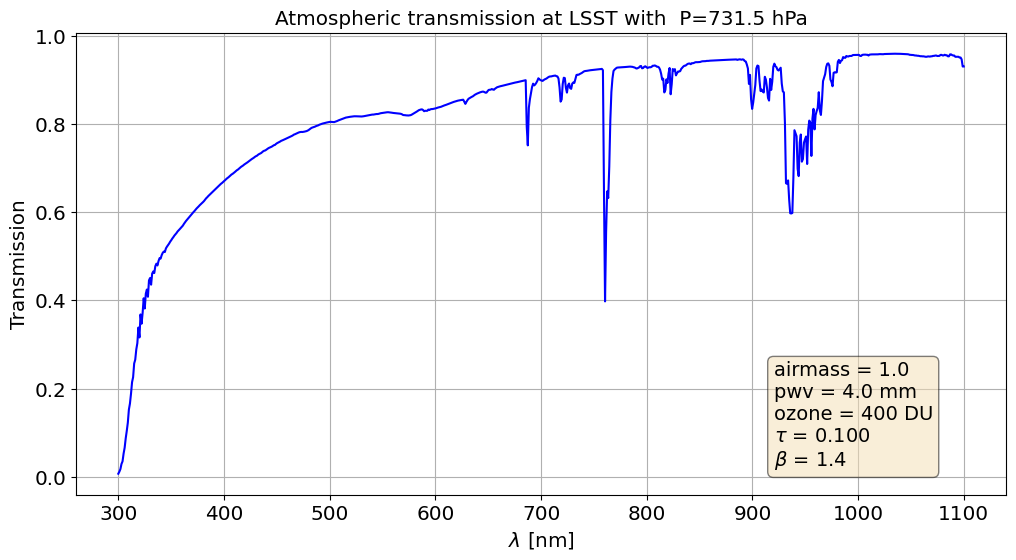

In [14]:
emul1.plot_transmission()

# Setting atmospheric parameters

In [15]:
WL = emul1.GetWL()
airmasses = emul1.AIRMASS
NAM = len(airmasses)
pwvs = emul1.PWV
NPWV = len(pwvs)
ozs = emul1.OZ
NOZ = len(ozs)

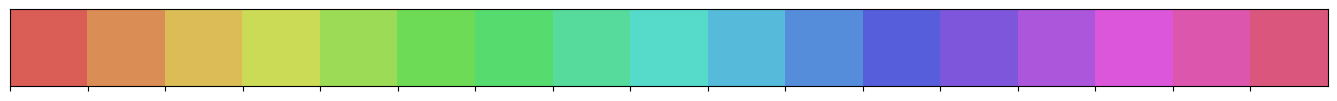

In [16]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

## Check emulator with Rayleigh scattering

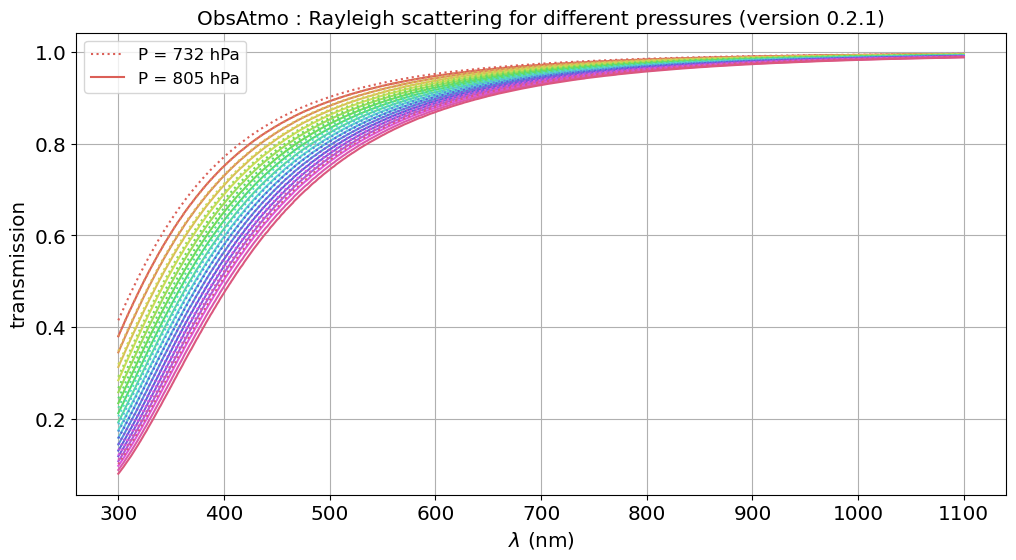

In [17]:
fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):

    transm1 = emul1.GetRayleighTransparencyArray(WL,am)
    transm2 = emul2.GetRayleighTransparencyArray(WL,am)
    
    if idx == 0:
        ax.plot(WL,transm1,":",color=hls_colors[idx],label=label1)
        ax.plot(WL,transm2,"-",color=hls_colors[idx],label=label2)
    else:
        ax.plot(WL,transm1,":",color=hls_colors[idx])
        ax.plot(WL,transm2,"-",color=hls_colors[idx])
    
title = f"ObsAtmo : Rayleigh scattering for different pressures (version {the_version})"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()


## Check emulator with Oxygen O2 absorption

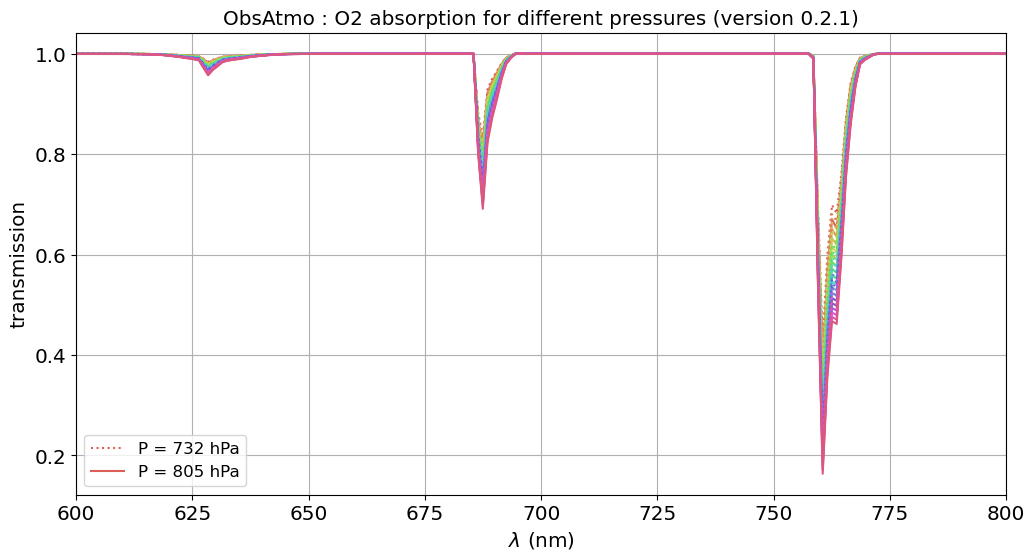

In [18]:
fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):

    transm1 = emul1.GetO2absTransparencyArray(WL,am)
    transm2 = emul2.GetO2absTransparencyArray(WL,am)
    
    if idx == 0:
        ax.plot(WL,transm1,":",color=hls_colors[idx],label=label1)
        ax.plot(WL,transm2,"-",color=hls_colors[idx],label=label2)
    else:
        ax.plot(WL,transm1,":",color=hls_colors[idx])
        ax.plot(WL,transm2,"-",color=hls_colors[idx])
        

title = f"ObsAtmo : O2 absorption for different pressures (version {the_version})"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(600.,800.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

### Zoom at the O2 abs line at 760 nm

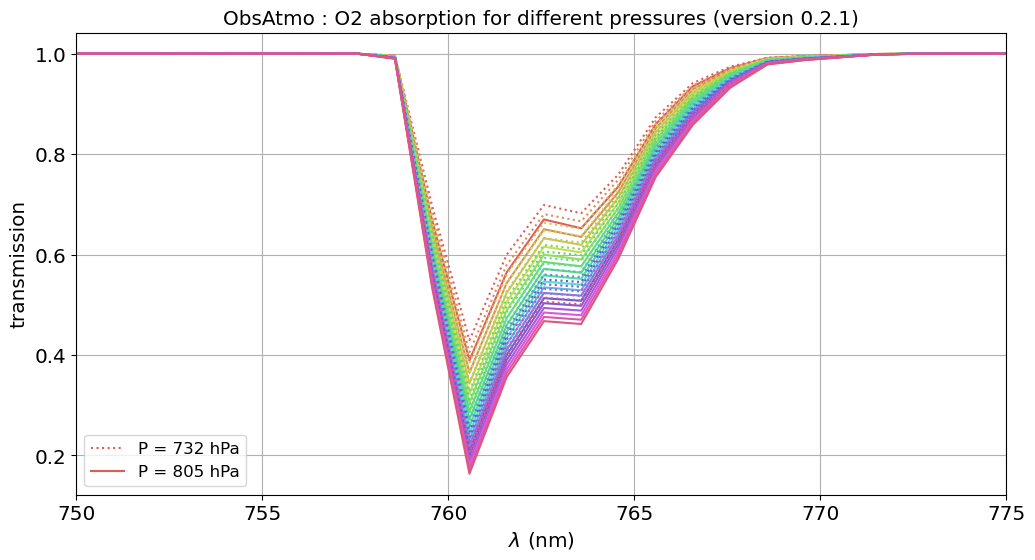

In [19]:
fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):

    transm1 = emul1.GetO2absTransparencyArray(WL,am)
    transm2 = emul2.GetO2absTransparencyArray(WL,am)
    
    if idx == 0:
        ax.plot(WL,transm1,":",color=hls_colors[idx],label=label1)
        ax.plot(WL,transm2,"-",color=hls_colors[idx],label=label2)
    else:
        ax.plot(WL,transm1,":",color=hls_colors[idx])
        ax.plot(WL,transm2,"-",color=hls_colors[idx])
        

title = f"ObsAtmo : O2 absorption for different pressures (version {the_version})"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(750.,775.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

## Check emulator with PWV absorption

Expect no difference

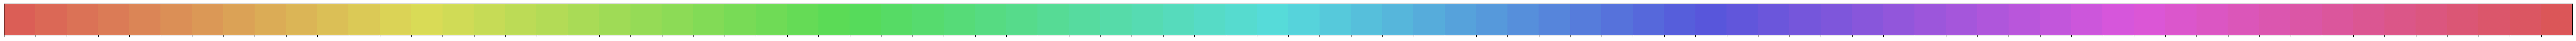

In [20]:
hls_colors = sns.color_palette("hls", NPWV)
sns.palplot(hls_colors)

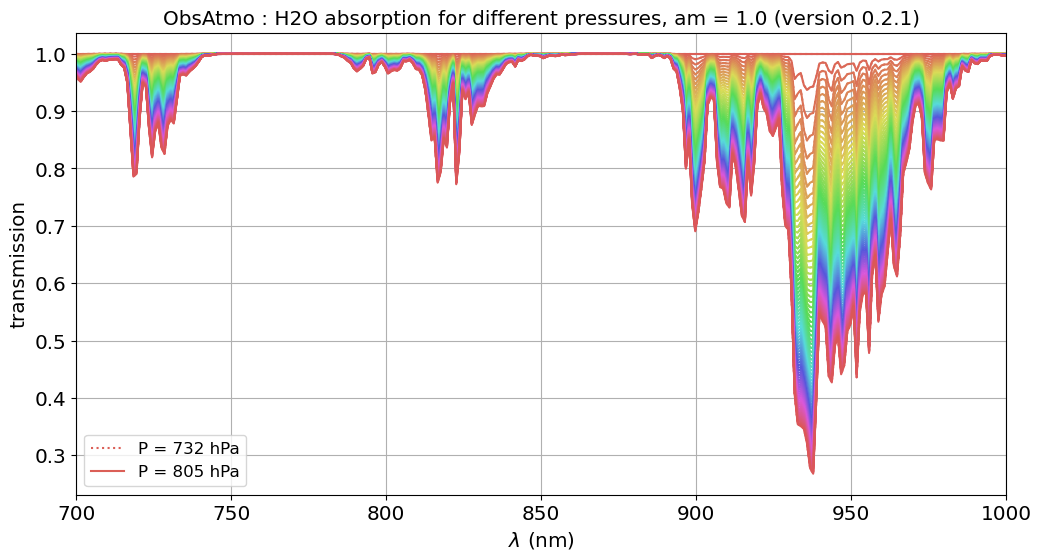

In [21]:
am =1

fig, ax = plt.subplots()
for idx,pwv in enumerate(pwvs):

    transm1 = emul1.GetPWVabsTransparencyArray(WL,am,pwv)
    transm2 = emul2.GetPWVabsTransparencyArray(WL,am,pwv)
    
    if idx == 0:
        ax.plot(WL,transm1,":",color=hls_colors[idx],label=label1)
        ax.plot(WL,transm2,"-",color=hls_colors[idx],label=label2)
    else:
        ax.plot(WL,transm1,":",color=hls_colors[idx])
        ax.plot(WL,transm2,"-",color=hls_colors[idx])
        

title = f"ObsAtmo : H2O absorption for different pressures, am = {am:.1f} (version {the_version})"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(700.,1000.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()



## Check emulator with Ozone absorption

- expect no difference

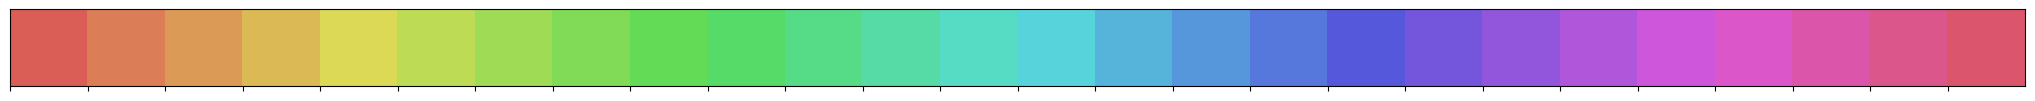

In [22]:
hls_colors = sns.color_palette("hls", NOZ)
sns.palplot(hls_colors)

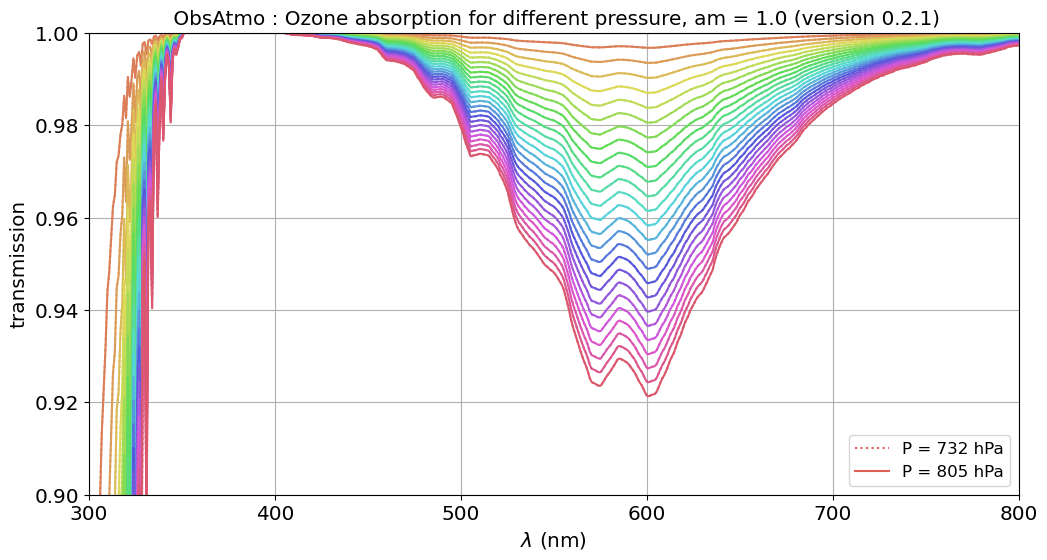

In [23]:
am =1

fig, ax = plt.subplots()
for idx,oz in enumerate(ozs):

    transm1 = emul1.GetOZabsTransparencyArray(WL,am,oz)
    transm2 = emul2.GetOZabsTransparencyArray(WL,am,oz)
    
    if idx == 0:
        ax.plot(WL,transm1,":",color=hls_colors[idx],label=label1)
        ax.plot(WL,transm2,"-",color=hls_colors[idx],label=label2)
    else:
        ax.plot(WL,transm1,":",color=hls_colors[idx])
        ax.plot(WL,transm2,"-",color=hls_colors[idx])
        

title = f" ObsAtmo : Ozone absorption for different pressure, am = {am:.1f} (version {the_version})"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(300.,800.)
ax.set_ylim(0.9,1.0)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()



## Check emulator with combined ascattering and absorption process and check with libradtran

In [24]:
am0 = 1.0
pwv0 = 5.0
oz0 = 500.
transm1 = emul1.GetGriddedTransparencies(WL,am0,pwv0,oz0,flagRayleigh=True)
transm2 = emul2.GetGriddedTransparencies(WL,am0,pwv0,oz0,flagRayleigh=True)

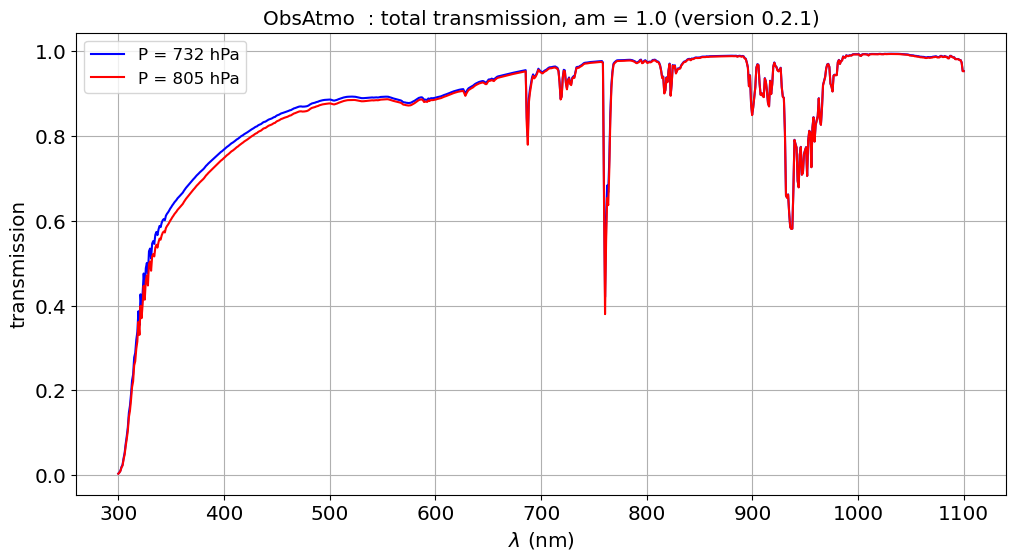

In [25]:
fig, ax = plt.subplots()

ax.plot(WL,transm1,'b-',label=label1)
ax.plot(WL,transm2,'r-',label=label2)

title = f"ObsAtmo  : total transmission, am = {am0:.1f} (version {the_version})"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

### Zoom at O2 absorption lines

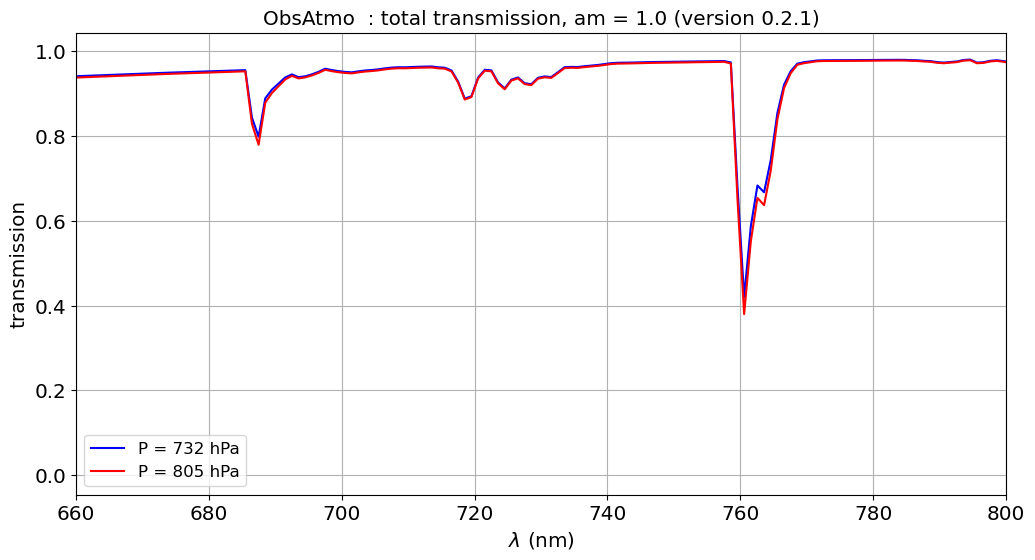

In [26]:
fig, ax = plt.subplots()

ax.plot(WL,transm1,'b-',label=label1)
ax.plot(WL,transm2,'r-',label=label2)

title = f"ObsAtmo  : total transmission, am = {am0:.1f} (version {the_version})"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(660.,800.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

## Check aerosols

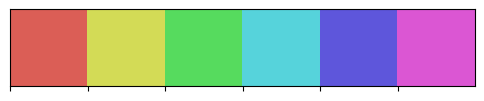

In [27]:
all_taus = np.arange(0,0.3,0.05)
NAER = len(all_taus) 
hls_colors = sns.color_palette("hls", NAER)
sns.palplot(hls_colors)

(0.0, 1.0)

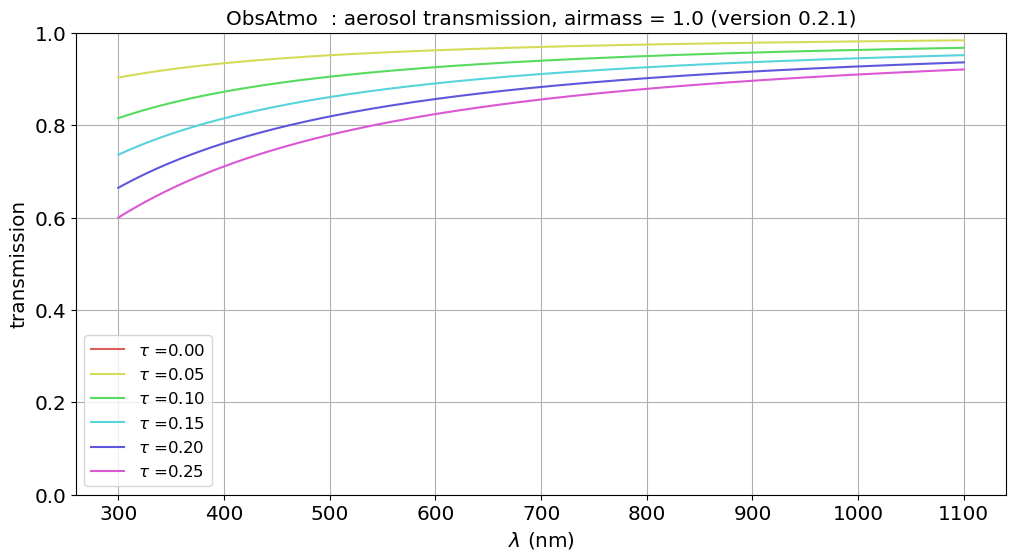

In [28]:
fig, ax = plt.subplots()
for index,tau in enumerate(all_taus):
    transm = emul1.GetAerosolsTransparencies(WL,am,tau) 
    label = r"$\tau$ =" + f"{tau:.2f}"
    ax.plot(WL,transm,color=hls_colors[index],label=label)
title = f"ObsAtmo  : aerosol transmission, airmass = {am:.1f} (version {the_version})"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()
ax.set_ylim(0,1)

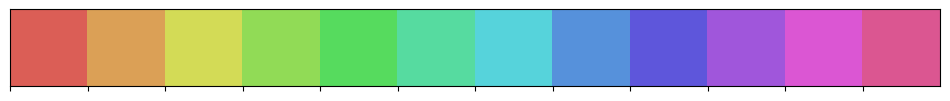

In [29]:
all_betas = np.arange(0.1,2.5,0.2)
NAER = len(all_betas) 
hls_colors = sns.color_palette("hls", NAER)
sns.palplot(hls_colors)
tau = 0.1

(0.5, 1.05)

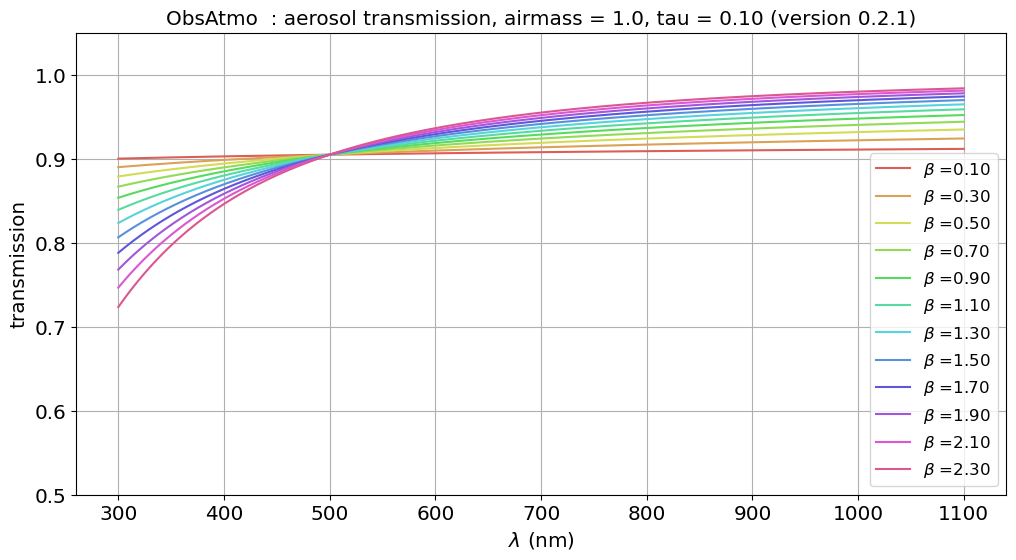

In [30]:
fig, ax = plt.subplots()
for index,beta in enumerate(all_betas):
    transm = emul1.GetAerosolsTransparencies(WL,am,tau,beta) 
    label = r"$\beta$ =" + f"{beta:.2f}"
    ax.plot(WL,transm,color=hls_colors[index],label=label)
title = f"ObsAtmo  : aerosol transmission, airmass = {am:.1f}, tau = {tau:.2f} (version {the_version})"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()
ax.set_ylim(0.5,1.05)

# The standard way to call atmospheric transmission

In [31]:
sorted_site_by_pressure = sorted(Dict_Of_sitesPressures.items(), key=lambda x:x[1])
sorted_site_by_pressure

[('OMK', 600.17224),
 ('PDM', 710.90637),
 ('LSST', 731.50433),
 ('VLT', 734.08038),
 ('CTIO', 774.6052),
 ('ZTF', 823.60004),
 ('OHP', 937.22595),
 ('OSL', 1013.0)]

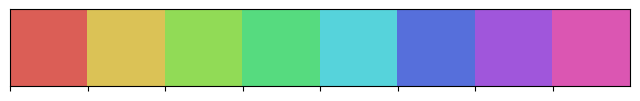

In [32]:
all_sites = sorted_site_by_pressure
NSites = len(all_sites)
hls_colors = sns.color_palette("hls", NSites)
sns.palplot(hls_colors)

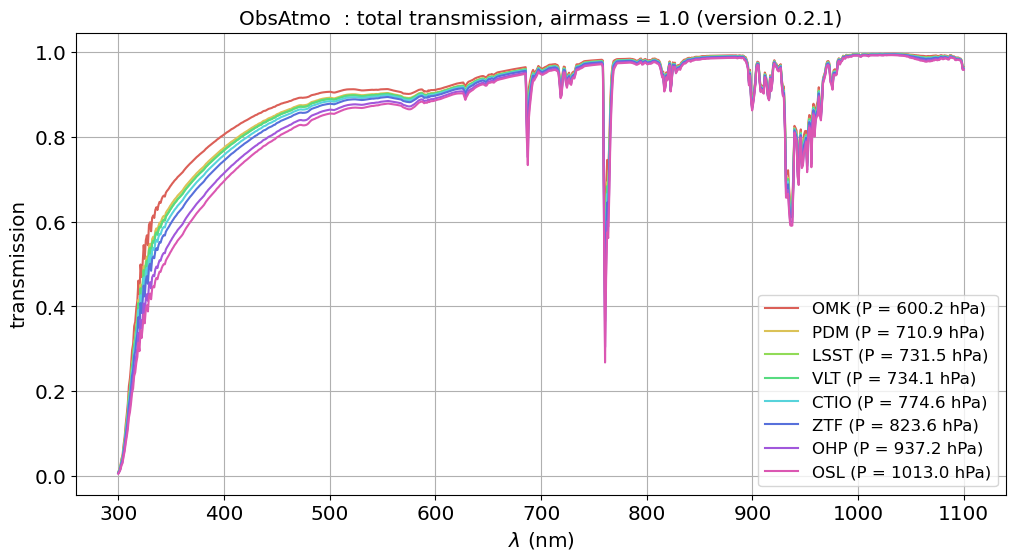

In [33]:
am=1
pwv = 4.0
oz= 400.
tau = 0.
beta = 3

fig, ax = plt.subplots()

for idx,site in enumerate(all_sites):

    obs_str = site[0]
    ref_press = site[1]
    
    emul = ObsAtmo(obs_str)
    pressure= emul.pressure
    
    label= f"{obs_str} (P = {pressure:.1f} hPa)"
    
    transm = emul.GetAllTransparencies(WL,am,pwv,oz,tau,beta)
    ax.plot(WL,transm,'-',color=hls_colors[idx],label=label)

title = f"ObsAtmo  : total transmission, airmass = {am:.1f} (version {the_version})"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

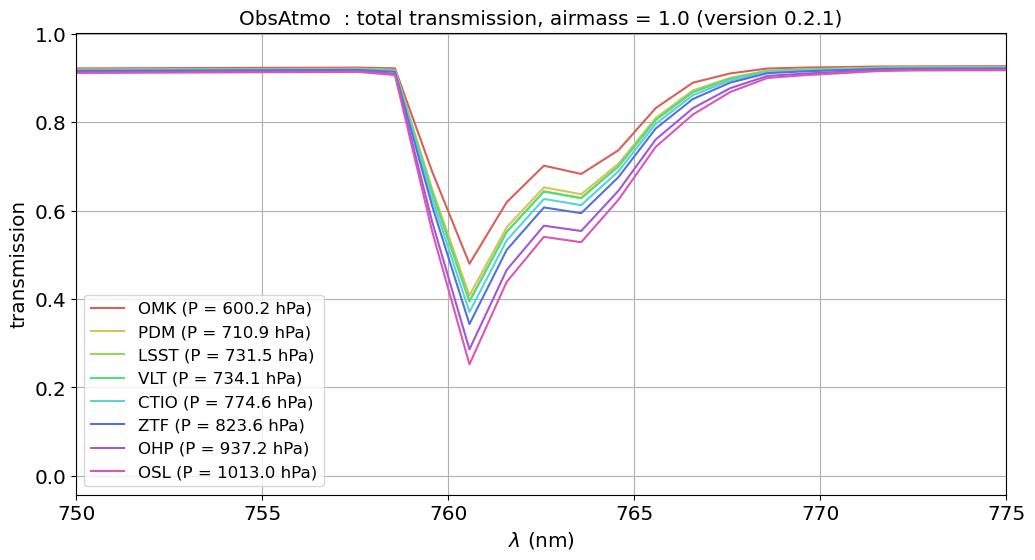

In [34]:
am=1
pwv = 4.0
oz= 400.
tau = 0.1
beta = 1.2

fig, ax = plt.subplots()

for idx,site in enumerate(all_sites):

    obs_str = site[0]
    ref_press = site[1]
    
    emul = ObsAtmo(obs_str)
    pressure= emul.pressure
    
    label= f"{obs_str} (P = {pressure:.1f} hPa)"
    
    transm = emul.GetAllTransparencies(WL,am,pwv,oz,tau,beta)
    ax.plot(WL,transm,'-',color=hls_colors[idx],label=label)

title = f"ObsAtmo  : total transmission, airmass = {am:.1f} (version {the_version})"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(750.,775.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()